In [3]:
!pip install gensim
!pip install umap-learn
!pip install hdbscan
!pip install seaborn

  Using cached hdbscan-0.8.29.tar.gz (5.2 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached Cython-0.29.33-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (2.0 MB)
  error: subprocess-exited-with-error
  
  × Building wheel for hdbscan (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [53 lines of output]
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build/lib.linux-x86_64-cpython-39
      creating build/lib.linux-x86_64-cpython-39/hdbscan
      copying hdbscan/__init__.py -> build/lib.linux-x86_64-cpython-39/hdbscan
      copying hdbscan/flat.py -> build/lib.linux-x86_64-cpython-39/hdbscan
      copying hdbscan/hdbscan_.py -> build/lib.linux-x86_64-cpython-39/hdbscan
      copying hdbscan/plots.py -> build/lib.linux-x86_64-cpython-39/hdbscan
      copying hdbscan/prediction.py -

In [1]:
import os
import re
from glob import glob
import json
import jsonlines
import spacy
import numpy as np
import gensim
import pandas as pd
from gensim.models import Word2Vec
from umap import UMAP
#import hdbscan
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
import seaborn as sns

In [21]:
with open('node_feature.json') as f:
    node_features = json.load(f)
words = list(node_features.keys())
print(len(words))

4620


In [22]:
class IterableSentences(object):
    def __init__(self, filename, lowercase=True, remove_punctuations=True):
        self.filename = filename
        self.lowercase = lowercase
        self.remove_punctuations = remove_punctuations
        
    def __iter__(self):
        sentences = []
        with open(self.filename, 'r') as f:
            for i in f.readlines():
                sentences.append(json.loads(i)["title"][0])
        for sentence in sentences:
            if self.lowercase:
                sentence = sentence.lower()
            if self.remove_punctuations:
                sentence = re.sub(pattern=r'[\!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]|\n', repl='', string=sentence).strip()
                yield sentence.split(' ')
            else:
                yield sentence.split()

In [23]:
sentences = IterableSentences(filename='/home1/khyeon/Researches/2_Text_mining/KBRS/ReRAM/ReRAM.jsonl', lowercase=True, remove_punctuations=True)

In [24]:
custom_model = Word2Vec(sentences=sentences, 
                        vector_size=300,      # Dimensionality of the word vectors
                        window=5,      # Context window for words during training
                        min_count=1,   # Ignores words with total frequency lower than this
                        workers=4,     # Number of threads to run in parallel
                        epochs=10,       # Number of epochs training over the corpus
                        seed=42)

In [25]:
word_list = []
vector_list = []
for word in words:
    if word in custom_model.wv:
        word_list.append(word)
        vector_list.append(custom_model.wv[word])
print(len(word_list), len(vector_list))
print(len(words))

3429 3429
4620


In [26]:
print(len(custom_model.wv))

9798


In [27]:
umap_model = UMAP(n_neighbors=5, min_dist=0.03, n_components=2, random_state=42)
umap_model.fit(vector_list)

#cluster_model = hdbscan.HDBSCAN(min_cluster_size=10, metric='euclidean', cluster_selection_method='leaf', prediction_data=True)
cluster_model = KMeans(n_clusters=10, random_state=42)
cluster_model.fit(umap_model.embedding_)

/home/khyeon/anaconda3/envs/KBRS/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=10, random_state=42)

In [28]:
results = pd.DataFrame({'word': word_list, 'cluster': cluster_model.labels_, 'vector': umap_model.embedding_.tolist()})

<Axes: xlabel='vector', ylabel='vector'>

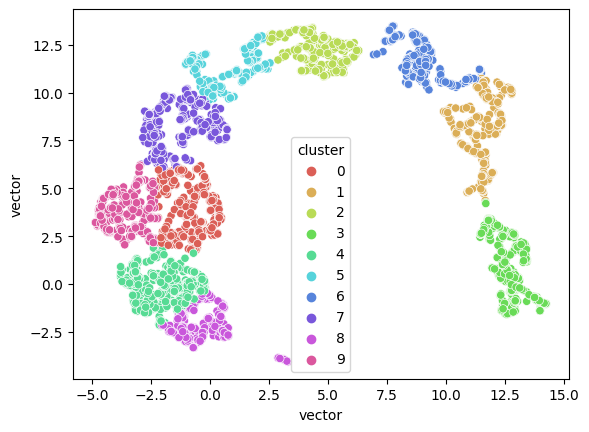

In [29]:
sns.scatterplot(x=results['vector'].apply(lambda x: x[0]), y=results['vector'].apply(lambda x: x[1]), hue=results['cluster'], palette=sns.color_palette('hls', 10))

In [33]:
results[results["cluster"] == 0]

,word,cluster,vector
0,igzo,0,"[-0.4163561165332794, 6.16278076171875]"
93,bn,0,"[-0.496299147605896, 2.1600403785705566]"
114,precursor,0,"[0.2424713373184204, 3.579082489013672]"
142,non,0,"[-1.1587086915969849, 5.837460041046143]"
156,taon,0,"[0.49523311853408813, 3.4424149990081787]"
...,...,...,...
3370,polyester,0,"[-1.8903982639312744, 5.697055816650391]"
3379,surgery,0,"[-0.2229929268360138, 5.609050273895264]"
3390,trinuclear,0,"[-0.5287323594093323, 6.0140204429626465]"
3413,bci,0,"[-1.6794027090072632, 5.788876056671143]"
